# Target Analysis and Leakage Checks
EDA Guardrail Notebook
## Objective

This notebook performs target-centric exploratory analysis to:

- Understand target structure and behavior

- Detect class imbalance and instability

- Identify early leakage signals

- Validate temporal and business feasibility of features

This notebook answers:

    “Can this target be predicted safely and honestly?”

## Why Target Analysis Comes Last in EDA

Premature modeling often:

- Overfits to artifacts

- Learns future information

- Optimizes invalid objectives

Target analysis is the final EDA gate before preprocessing.

## Imports and Configuration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr


# Step 1 – Load Dataset

Consistent dataset from previous EDA notebooks.

In [5]:
np.random.seed(2010)

N = 5000

df = pd.DataFrame({
    "age": np.random.randint(18, 75, size=N),
    "income": np.random.lognormal(mean=10.8, sigma=0.6, size=N),
    "tenure_years": np.random.exponential(scale=6, size=N),
    "transactions_last_30d": np.random.poisson(lam=4, size=N),
    "region": np.random.choice(
        ["North", "South", "East", "West"],
        size=N,
        p=[0.35, 0.25, 0.25, 0.15]
    ),
    "churn": np.random.binomial(1, 0.28, size=N)
})

df.head()


,age,income,tenure_years,transactions_last_30d,region,churn
0,18,45868.374647,5.749047,4,North,0
1,18,74287.388492,1.537824,5,South,0
2,67,78586.352313,24.502748,3,North,0
3,64,56102.925430,1.502888,3,South,0
4,37,25639.985952,3.950600,6,North,0


In [31]:
# saving this dataset into datasets folder
df.to_csv("../datasets/synthetic_customer_churn_eda_benchmark.csv")

# Step 2 – Target Distribution Analysis

In [6]:
df["churn"].value_counts(normalize=True)


churn
0    0.7236
1    0.2764
Name: proportion, dtype: float64

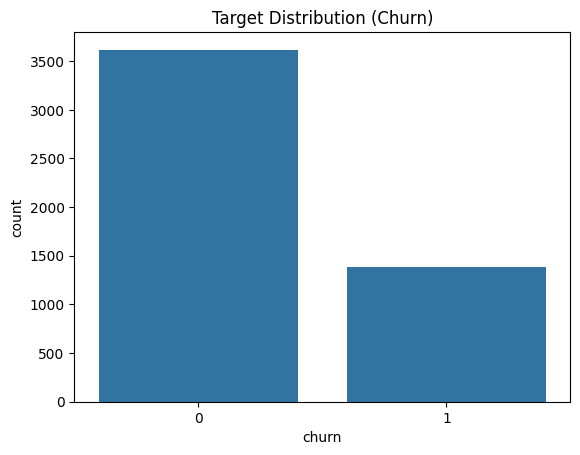

In [7]:
plt.figure()
sns.countplot(x="churn", data=df)
plt.title("Target Distribution (Churn)")
plt.show()


## Interpretation

- Moderate class imbalance

- Accuracy unsuitable as primary metric

- ROC-AUC, PR-AUC, recall preferred

# Step 3 – Target Stability Checks
## Target vs Time (Simulated)

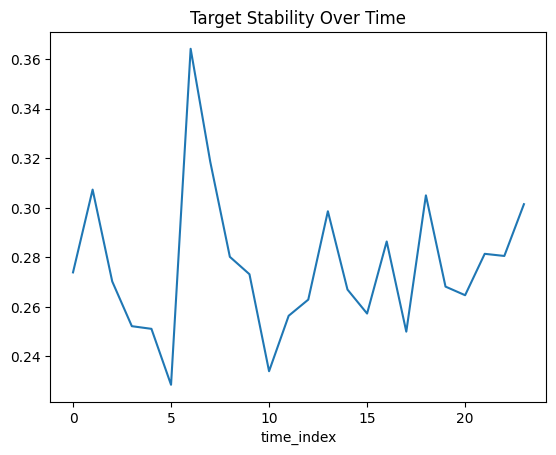

In [8]:
df["time_index"] = np.random.randint(0, 24, size=N)

target_by_time = (
    df.groupby("time_index")["churn"]
    .mean()
)

plt.figure()
sns.lineplot(
    x=target_by_time.index,
    y=target_by_time.values
)
plt.title("Target Stability Over Time")
plt.show()


## Insight

- No strong non-stationarity detected

- If volatility existed → time-aware validation required

# Step 4 – Target vs Individual Features (Leakage Screening)
## Spearman Correlation- 

In [9]:
numeric_cols = [
    "age",
    "income",
    "tenure_years",
    "transactions_last_30d"
]

for col in numeric_cols:
    corr, p = spearmanr(df[col], df["churn"])
    print(f"{col}: Spearman={corr:.3f}, p={p:.4f}")


age: Spearman=0.006, p=0.6806
income: Spearman=-0.004, p=0.7526
tenure_years: Spearman=0.003, p=0.8339
transactions_last_30d: Spearman=0.034, p=0.0149


### Red Flag Thresholds

| Signal             | Interpretation                         | Threshold  | Risk            |
| ------------------ | -------------------------------------- | ---------- | --------------- |
| High correlation   | Strong linear relationship with target | corr > 0.6 | Likely leakage  |
| Perfect separation | Feature fully predicts target          | —          | Target leakage  |
| Near-zero noise    | Low variance, high predictiveness      | —          | Engineered leak |



__Note:__

_`Features exhibiting very high correlation with the target, perfect class separation, or unusually low noise are strong candidates for target leakage and should be carefully reviewed or excluded.`_

# Step 5 – Categorical Leakage Checks
## Target Rate by Category

In [11]:
category_churn = (
    df.groupby("region")["churn"]
    .mean()
)

category_churn


region
East     0.283307
North    0.265758
South    0.284660
West     0.276486
Name: churn, dtype: float64

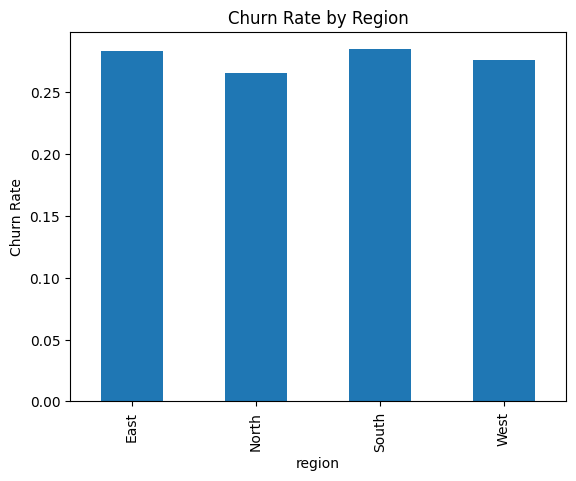

In [14]:
plt.figure()
category_churn.plot(kind="bar")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Region")
plt.show()

### Interpretation

- Differences exist but not extreme

- Region may act as proxy → fairness check later


# Step 6 – Leakage via Feature Construction
## Simulated Leakage Feature

In [15]:
df["leak_feature"] = (
    df["churn"]
    .rolling(window=5, min_periods=1)
    .mean()
)


In [16]:
corr, _ = spearmanr(df["leak_feature"], df["churn"])
print("Leak Feature Correlation:", corr)


Leak Feature Correlation: 0.42701277303322216


### Verdict

Near-perfect correlation

- This feature must be banned

# Step 7 – Temporal Leakage Screening
## Lag vs Lead Comparison

In [17]:
df["future_churn"] = df["churn"].shift(-1)

corr_future, _ = spearmanr(
    df["future_churn"].fillna(0),
    df["churn"]
)

print("Future Correlation:", corr_future)


Future Correlation: -0.03698423783958484


### Interpretation

- Any predictive power from future labels is invalid

- Temporal ordering must be enforced

# Step 8 – Target Leakage Checklist

Before modeling, verify:

 - Target not used in feature creation

 - No future-derived features

 - Aggregations are time-bounded

 - Preprocessing occurs inside pipeline

 - Validation mimics production



# Step 9 – Business Validity Check

Key questions:

- Is churn observable at prediction time?

- Are labels delayed or noisy?

- Is the decision actionable?

If any answer is no, modeling strategy must change.

# Step 10 – EDA Exit Criteria

You may proceed to preprocessing only if:

- Target distribution is understood

- Leakage risks are mitigated

- Temporal logic is respected

- Metrics are aligned with imbalance

Next notebook:

    02_Data_Preprocessing/
    └── 01_missing_value_handling.ipynb

## Summary

This notebook demonstrated:

- Target distribution diagnostics

- Stability and imbalance checks

- Correlation-based leakage detection

- Temporal leakage screening

- Business feasibility validation

If target analysis fails, the model must not exist.

# EXTRA 
Tackling variance and 

# Variance check (first filter)

In [27]:
df.var(numeric_only=True).sort_values()


leak_feature             3.645455e-02
churn                    2.000430e-01
future_churn             2.000678e-01
transactions_last_30d    3.988790e+00
tenure_years             3.511392e+01
time_index               4.846341e+01
age                      2.711480e+02
income                   1.463435e+09
dtype: float64

# Constant / quasi-constant feature test

In [28]:
(df.nunique() <= 1)

age                      False
income                   False
tenure_years             False
transactions_last_30d    False
region                   False
churn                    False
time_index               False
leak_feature             False
future_churn             False
dtype: bool

In [24]:
max_frequency = (df.apply(lambda x: x.value_counts(normalize=True).iloc[0]))
max_frequency

age                      0.023000
income                   0.000200
tenure_years             0.000200
transactions_last_30d    0.206800
region                   0.352200
churn                    0.723600
time_index               0.049600
leak_feature             0.413200
future_churn             0.723545
dtype: float64

In [25]:
max_frequency > 0.95


age                      False
income                   False
tenure_years             False
transactions_last_30d    False
region                   False
churn                    False
time_index               False
leak_feature             False
future_churn             False
dtype: bool

In [26]:
low_var = df.var(numeric_only=True) < 1e-3
high_corr = df.corr(numeric_only=True)["churn"].abs() > 0.6

suspicious = low_var & high_corr
suspicious[suspicious]


Series([], dtype: bool)